In [ ]:
import os
import cv2               #histogram equalization
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [ ]:
#Fixed Random Seeds
import os
import random
import numpy as np
import tensorflow as tf

# ---------- Reproducibility ----------
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# -------------------------------------


In [ ]:
CONFIG = {
    "img_size": (32, 32),
    "batch_size": 32,
    "epochs": 30,
    "learning_rate": 1e-3,
    "optimizer": "adam",
    "dropout_block": 0.25,
    "dropout_fc": 0.5,
    "num_classes": 10,
}
print("Config:", CONFIG)


Config: {'img_size': (32, 32), 'batch_size': 32, 'epochs': 30, 'learning_rate': 0.001, 'optimizer': 'adam', 'dropout_block': 0.25, 'dropout_fc': 0.5, 'num_classes': 10}


In [ ]:
import os
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from PIL import Image

# ------------ CONFIG ------------
BASE_DIR = "cifar10_10000"   # folder that will be created in your current directory
TOTAL_IMAGES = 10000         # total images to keep
# -------------------------------

# CIFAR-10 class names (index -> name)
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# 1. Load full CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.ravel()
y_test  = y_test.ravel()

print("Original CIFAR-10 shapes:")
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test: ", x_test.shape,  "y_test: ", y_test.shape)

# 2. Combine train + test (60000 images)
X = np.concatenate([x_train, x_test], axis=0)   # (60000, 32, 32, 3)
y = np.concatenate([y_train, y_test], axis=0)   # (60000,)

# 3. Take a stratified subset of TOTAL_IMAGES (≈ 400/class)
X_small, _, y_small, _ = train_test_split(
    X, y,
    train_size=TOTAL_IMAGES,
    stratify=y,
    random_state=42
)

print("Subset:", X_small.shape, y_small.shape)

# 4. Split into train / val / test = 60% / 20% / 20%
X_train, X_temp, y_train, y_temp = train_test_split(
    X_small, y_small,
    train_size=0.7,           # 2400 images
    stratify=y_small,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    train_size=0.5,           # 800 / 800
    stratify=y_temp,
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

# 5. Helper: save a split (X_split, y_split) into folders
def save_split(split_name, X_split, y_split):
    for idx, (img, label) in enumerate(zip(X_split, y_split)):
        class_name = class_names[label]
        # Folder path, e.g. cifar10_4000/train/airplane
        class_dir = os.path.join(BASE_DIR, split_name, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Ensure uint8 (0-255)
        if img.dtype != np.uint8:
            img_uint8 = (img * 255).astype(np.uint8)
        else:
            img_uint8 = img

        # Create PIL Image and save
        im = Image.fromarray(img_uint8)
        filename = f"{split_name}_{class_name}_{idx:05d}.png"
        im.save(os.path.join(class_dir, filename))

# 6. Save all three splits
save_split("train", X_train, y_train)
save_split("val",   X_val,   y_val)
save_split("test",  X_test,  y_test)

print(f"Saved dataset under '{BASE_DIR}' folder.")


Original CIFAR-10 shapes:
x_train: (50000, 32, 32, 3) y_train: (50000,)
x_test:  (10000, 32, 32, 3) y_test:  (10000,)
Subset: (10000, 32, 32, 3) (10000,)
Train: (7000, 32, 32, 3) (7000,)
Val:   (1500, 32, 32, 3) (1500,)
Test:  (1500, 32, 32, 3) (1500,)
Saved dataset under 'cifar10_10000' folder.


In [ ]:
import tensorflow as tf
import os

DATA_DIR   = "cifar10_10000"
IMG_SIZE   = (32, 32)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_SIZE   = CONFIG["img_size"]
BATCH_SIZE = CONFIG["batch_size"]
AUTOTUNE   = tf.data.AUTOTUNE

train_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_raw.class_names
print("Classes:", class_names)


Found 7000 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


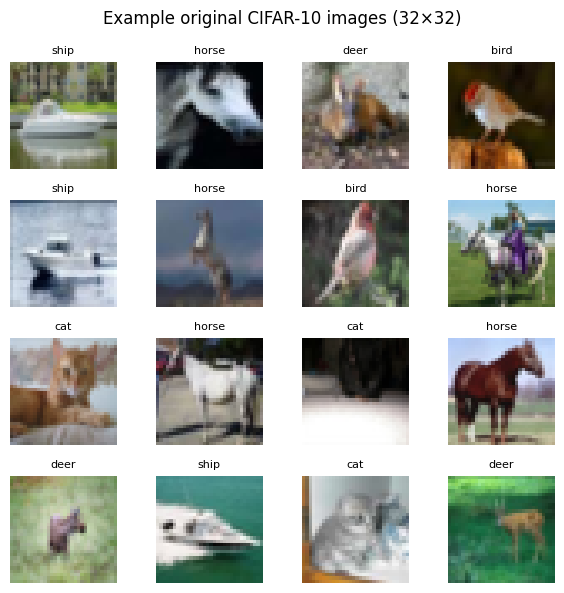

In [ ]:

#“CIFAR-10 images are low-resolution (32×32 RGB), so sample images in the report appear pixelated when upscaled; this is inherent to the dataset and not due to preprocessing.”
for images, labels in train_raw.take(1):
    images_batch = images.numpy().astype("uint8")
    labels_batch = np.argmax(labels.numpy(), axis=1)
    break

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images_batch[i], interpolation="nearest")  # <- important
    plt.title(class_names[labels_batch[i]], fontsize=8)
    plt.axis("off")

plt.suptitle("Example original CIFAR-10 images (32×32)", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
#pre processing augmentation layers
from tensorflow.keras import layers, Sequential

# Data augmentation only used on training images
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

# Normalization layer (0-255 → 0-1)
normalization = layers.Rescaling(1.0 / 255.0, name="rescaling")


In [ ]:
def apply_clahe(image):
    """
    image: numpy array (H, W, 3) uint8, RGB
    returns: equalized RGB image, uint8
    """
    img = image.astype("uint8")

    # Convert RGB -> LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # CLAHE on L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    limg = cv2.merge((cl, a, b))
    equalized = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    return equalized


In [ ]:
def histogram_equalization_tf(image):
    # image: tf.Tensor, uint8, shape (H, W, 3)
    equalized = tf.numpy_function(apply_clahe, [image], tf.uint8)
    equalized.set_shape(image.shape)  # keep static shape info
    return equalized


In [ ]:
#attach preprocessing and augmentation to data sets
def prepare_train(images, labels):
    # 1) Histogram equalization (CLAHE) per image
    images = tf.map_fn(histogram_equalization_tf, images, dtype=tf.uint8)

    # 2) Data augmentation
    images = data_augmentation(images)

    # 3) Normalization to [0,1]
    images = normalization(images)
    return images, labels


def prepare_eval(images, labels):
    #same preprocessing (without augmentation) for val & test
    images = tf.map_fn(histogram_equalization_tf, images, dtype=tf.uint8)
    images = normalization(images)
    return images, labels


train_ds = (
    train_raw
    .map(prepare_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_raw
    .map(prepare_eval, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_raw
    .map(prepare_eval, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [ ]:
#define lightweight CNN's
def build_cnn_model(input_shape=(32, 32, 3),
                    num_classes=10,
                    dropout_block=0.25,
                    dropout_fc=0.5):
    inputs = layers.Input(shape=input_shape, name="input_image")

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding="same", use_bias=False, name="conv1_1")(inputs)
    x = layers.BatchNormalization(name="bn1_1")(x)
    x = layers.ReLU(name="relu1_1")(x)

    x = layers.Conv2D(32, (3, 3), padding="same", use_bias=False, name="conv1_2")(x)
    x = layers.BatchNormalization(name="bn1_2")(x)
    x = layers.ReLU(name="relu1_2")(x)

    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = layers.Dropout(dropout_block, name="dropout1")(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding="same", use_bias=False, name="conv2_1")(x)
    x = layers.BatchNormalization(name="bn2_1")(x)
    x = layers.ReLU(name="relu2_1")(x)

    x = layers.Conv2D(64, (3, 3), padding="same", use_bias=False, name="conv2_2")(x)
    x = layers.BatchNormalization(name="bn2_2")(x)
    x = layers.ReLU(name="relu2_2")(x)

    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = layers.Dropout(dropout_block, name="dropout2")(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding="same", use_bias=False, name="conv3_1")(x)
    x = layers.BatchNormalization(name="bn3_1")(x)
    x = layers.ReLU(name="relu3_1")(x)

    x = layers.MaxPooling2D((2, 2), name="pool3")(x)
    x = layers.Dropout(dropout_block, name="dropout3")(x)

    # Head
    x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
    x = layers.Dense(128, use_bias=False, name="fc1")(x)
    x = layers.BatchNormalization(name="bn_fc1")(x)
    x = layers.ReLU(name="relu_fc1")(x)
    x = layers.Dropout(dropout_block, name="dropout_fc1")(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="lightweight_cnn")
    return model

In [ ]:
#model summary build
num_classes = len(class_names)

model = build_cnn_model(
    input_shape=CONFIG["img_size"] + (3,),
    num_classes=num_classes,
    dropout_block=CONFIG["dropout_block"],
    dropout_fc=CONFIG["dropout_fc"]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "lightweight_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 32, 32, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_2 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 16, 16, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_1 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 16, 16, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 8, 8, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 8, 8, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_1 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 158,570 (619.41 KB)

 Trainable params: 157,674 (615.91 KB)

 Non-trainable params: 896 (3.50 KB)

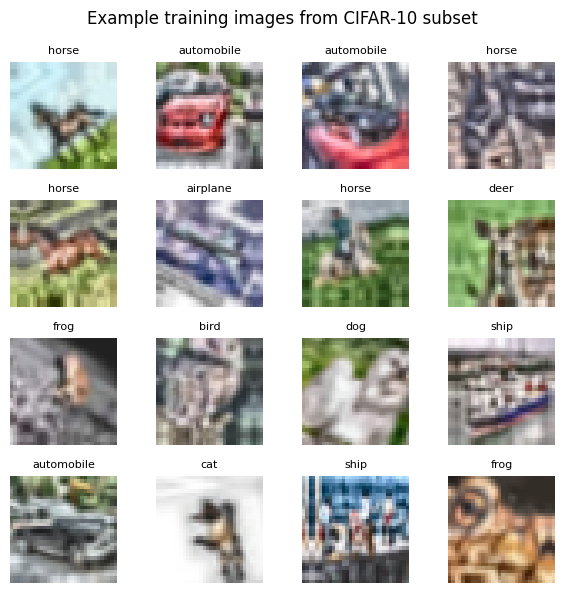

In [ ]:
#sample images visualizing after preprocessing & augmentation
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from train_ds
for images, labels in train_ds.take(1):
    images_batch = images.numpy()
    labels_batch = np.argmax(labels.numpy(), axis=1)
    break

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images_batch[i])
    plt.title(class_names[labels_batch[i]], fontsize=8)
    plt.axis("off")

plt.suptitle("Example training images from CIFAR-10 subset", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
pip install scikit-learn


In [ ]:
#training implementation - Set epochs + callbacks (EarlyStopping)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

EPOCHS = 30   # between 20–50, early stopping will stop earlier if needed

checkpoint_path = "best_lightweight_cnn.keras"  # saved best model

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,             # stop if val_loss doesn’t improve for 5 epochs
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1
    )
]


In [ ]:
EPOCHS = CONFIG["epochs"]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)



Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.2232 - loss: 2.1544
Epoch 1: val_loss improved from inf to 2.89698, saving model to best_lightweight_cnn.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 92s 365ms/step - accuracy: 0.2233 - loss: 2.1539 - val_accuracy: 0.1333 - val_loss: 2.8970 - learning_rate: 0.0010
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3134 - loss: 1.8549
Epoch 2: val_loss improved from 2.89698 to 2.14602, saving model to best_lightweight_cnn.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 61s 277ms/step - accuracy: 0.3135 - loss: 1.8548 - val_accuracy: 0.2713 - val_loss: 2.1460 - learning_rate: 0.0010
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3667 - loss: 1.7329
Epoch 3: val_loss did not improve from 2.14602
219/219 ━━━━━━━━━━━━━━━━━━━━ 84s 287ms/step - accuracy: 0.3667 - loss: 1.7329 - val_accuracy: 0.2560 - val_loss: 2.3154 - learning_rate: 0.0010
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.394

In [ ]:
#basic test accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.4787 - loss: 1.4597 
Test loss: 1.4838
Test accuracy: 0.4893


In [ ]:
#collect predection on test set
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    # labels are one-hot; model outputs probabilities
    preds = model.predict(images, verbose=0)

    y_true.append(np.argmax(labels.numpy(), axis=1))  # true class index
    y_pred.append(np.argmax(preds, axis=1))           # predicted class index

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print("Shapes:", y_true.shape, y_pred.shape)


Shapes: (1500,) (1500,)


In [ ]:
#training and eval : Precision, recall, F1-score, and confusion matrix
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# Per-class metrics + macro averages
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Explicit overall metrics
accuracy  = (y_true == y_pred).mean()
precision = precision_score(y_true, y_pred, average="macro")
recall    = recall_score(y_true, y_pred, average="macro")
f1        = f1_score(y_true, y_pred, average="macro")

print(f"\nOverall accuracy:       {accuracy:.4f}")
print(f"Macro precision:        {precision:.4f}")
print(f"Macro recall:           {recall:.4f}")
print(f"Macro F1-score:         {f1:.4f}")


Confusion matrix:
 [[ 72   5   8   2   3   2   7   0  47   4]
 [ 25  95   1   4   3   0   2   0  13   7]
 [  9   0  38  27  13  13  36   2  12   0]
 [  5   0   2  78   5  18  32   0   7   3]
 [ 11   0   7  28  46  10  39   5   4   0]
 [  6   1   5  41  11  65  13   1   7   0]
 [  5   0   2  19   4   5 114   0   1   0]
 [ 13   0   3  21  26  17  11  45   6   8]
 [ 11   1   4   3   2   0   4   0 121   4]
 [ 18  27   0   7   2   3   6   0  27  60]]

Classification report:
              precision    recall  f1-score   support

    airplane       0.41      0.48      0.44       150
  automobile       0.74      0.63      0.68       150
        bird       0.54      0.25      0.35       150
         cat       0.34      0.52      0.41       150
        deer       0.40      0.31      0.35       150
         dog       0.49      0.43      0.46       150
        frog       0.43      0.76      0.55       150
       horse       0.85      0.30      0.44       150
        ship       0.49      0.81      

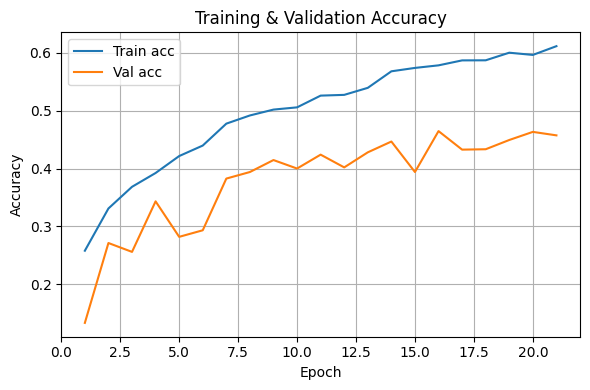

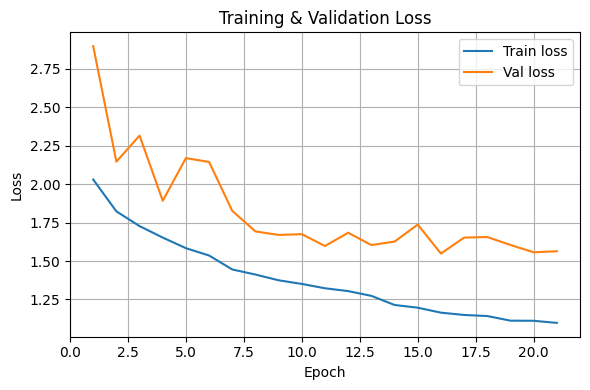

In [ ]:
def plot_training_curves(history):
    acc      = history.history["accuracy"]
    val_acc  = history.history["val_accuracy"]
    loss     = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs   = range(1, len(acc) + 1)

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(epochs, acc,     label="Train acc")
    plt.plot(epochs, val_acc, label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(epochs, loss,     label="Train loss")
    plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_curves(history)


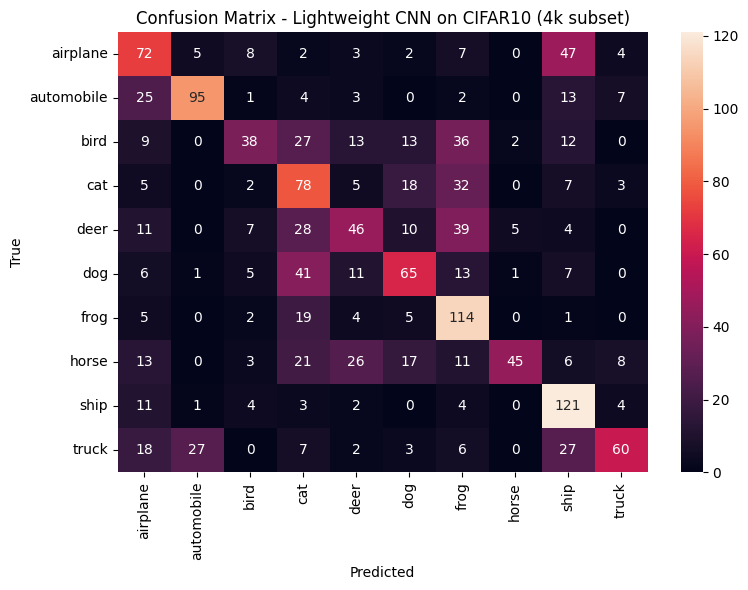

In [ ]:
#Pretty confusion matrix plot for report
import matplotlib.pyplot as plt
import seaborn as sns  # if you don't have it: pip install seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Lightweight CNN on CIFAR10 (4k subset)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers


In [ ]:
# Feauture visualization - Take one batch from test set
for test_images, test_labels in test_ds.take(1):
    sample_images = test_images[:5]          # first 5 images
    sample_labels = tf.argmax(test_labels[:5], axis=1)
    break

print(sample_images.shape, sample_labels.numpy())


(5, 32, 32, 3) [0 0 0 0 0]


In [ ]:
# Feauture Visualization - List all Conv2D layers in the model
conv_layers = [layer for layer in model.layers if isinstance(layer, layers.Conv2D)]
print("Number of conv layers:", len(conv_layers))
print([layer.name for layer in conv_layers])

# Model that outputs activations for each conv layer
activation_model = models.Model(
    inputs=model.input,
    outputs=[layer.output for layer in conv_layers]
)


Number of conv layers: 5
['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1']


In [ ]:
image = sample_images[0:1]  # shape (1, 32, 32, 3)

feature_maps = activation_model.predict(image)
print(len(feature_maps))           # one entry per conv layer
print(feature_maps[0].shape)      # e.g. (1, 16, 16, 32) etc.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
5
(1, 32, 32, 32)


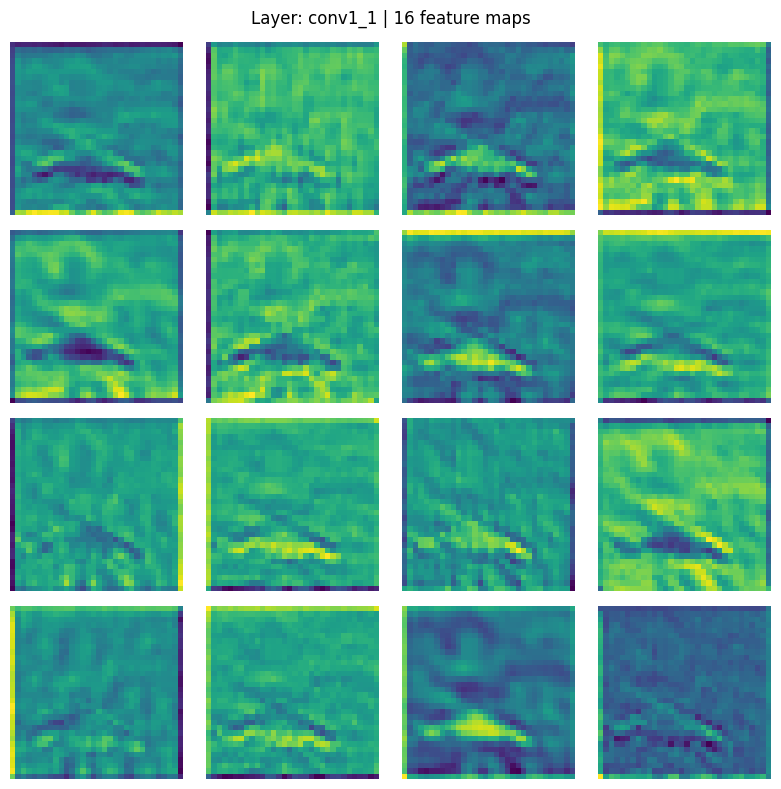

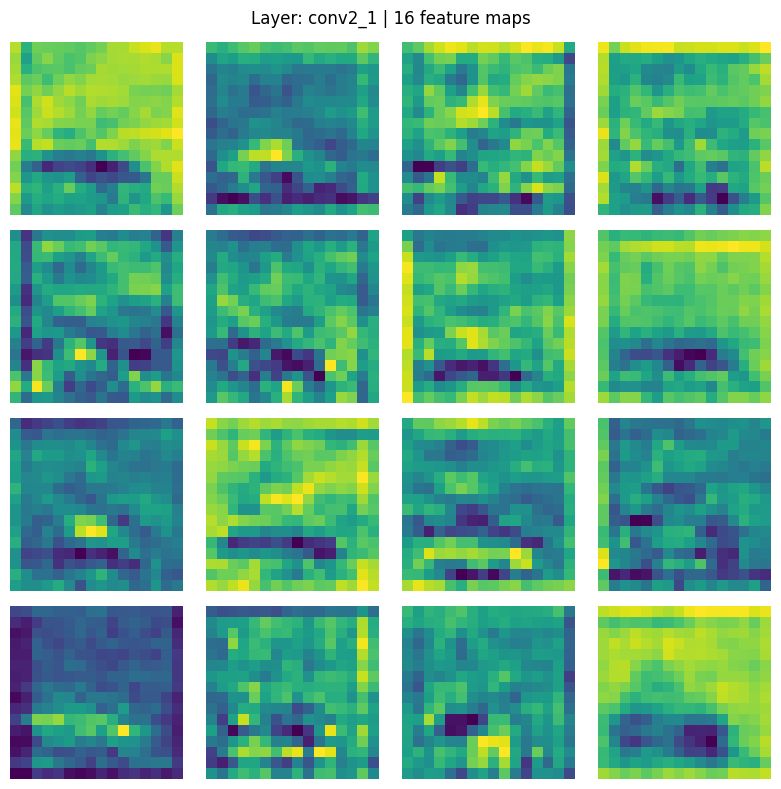

In [ ]:
#Feauture visualization plotting
def plot_feature_maps(feature_map, layer_name, max_channels=16):
    """
    feature_map: numpy array of shape (1, H, W, C)
    """
    fmap = feature_map[0]
    num_channels = min(fmap.shape[-1], max_channels)

    cols = 4
    rows = int(np.ceil(num_channels / cols))

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(num_channels):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(fmap[:, :, i], cmap="viridis")
        plt.axis("off")
    plt.suptitle(f"Layer: {layer_name} | {num_channels} feature maps", fontsize=12)
    plt.tight_layout()
    plt.show()

# Example: visualize first and third conv layers
plot_feature_maps(feature_maps[0], conv_layers[0].name)
if len(feature_maps) > 2:
    plot_feature_maps(feature_maps[2], conv_layers[2].name)


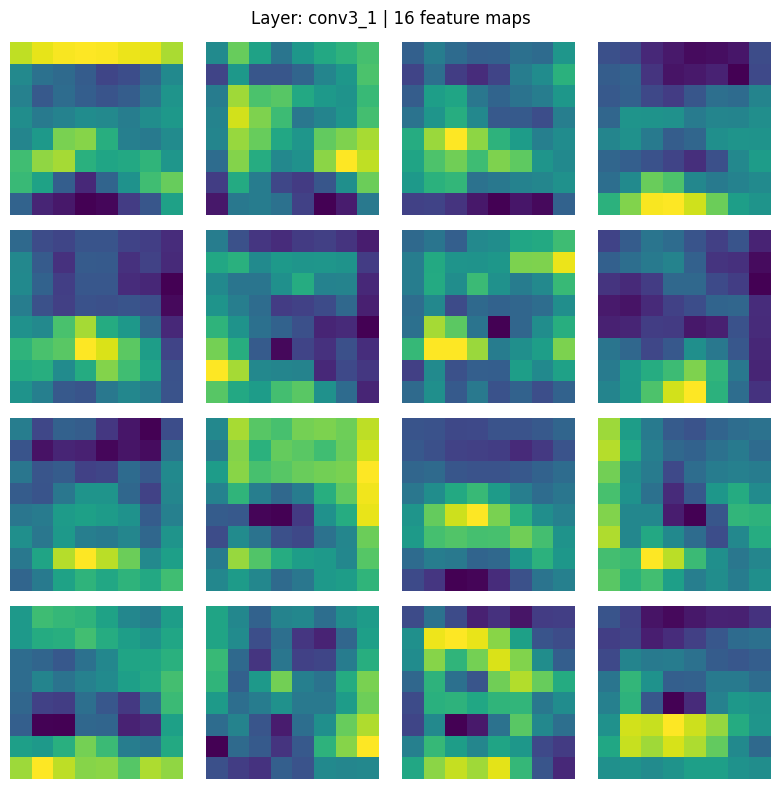

In [ ]:
# Deepest conv layer
plot_feature_maps(feature_maps[-1], conv_layers[-1].name)
